In [2]:
import tensorflow as tf # Models ran in venv python 3.9.16 with GPU computing support
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import ast
import ecg_plot
import os
import scipy.io as sio
print(tf.config.list_physical_devices()) # Verify you have a GPU available. Not required
print(tf.test.is_built_with_cuda())
print(tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [82]:
folder_path = "../data/WFDB/"
# Loops thorugh the .hea files and re formats them according to WFDB standards. This dataset included a .mat file type at the end and thew an error. 
# This loop modifies the .hea files by only removing the .mat text if its found on the line. 

for filename in os.listdir(folder_path):
    if filename.endswith(".hea"):
        file_path = os.path.join(folder_path, filename)
        
        # Read the contents of the .hea file
        with open(file_path, 'r') as file:
            lines = file.readlines()
        
        # Adjust and format the header lines to remove ".mat" at the end
        adjusted_lines = []
        for line in lines:
            adjusted_line = line.replace(".mat", "")
            adjusted_lines.append(adjusted_line)
        
        # Write the adjusted lines back to the .hea file
        with open(file_path, 'w') as file:
            file.writelines(adjusted_lines)

In [164]:
import os
import numpy as np
import wfdb
import tensorflow as tf
import traceback

folder_path = "../data/WFDB/"

def wfdb_mat_load(path):
    data = []
    for filename in os.listdir(path):
        if filename.endswith(".mat"):
            record_data = sio.loadmat(os.path.join(path, filename))
            if(record_data['val'].shape == (12,5000)):
                data.append(np.array(record_data['val']))
    return data


def wfdb_hea_load(path):
    hea_files = []
    for filename in os.listdir(path):
        if filename.endswith(".hea"):
            base_name, file_type = os.path.splitext(filename)
            file_path = os.path.join(path, base_name)
            header = wfdb.rdheader(path+base_name)
            hea_files.append(header)
    return hea_files

# Incorporates both loading functions so that any data excluded from X is removed from the corresponding Y.
def wfdb_loader(path):
    data = []    
    hea_files = []
    for filename in os.listdir(path):
        if filename.endswith(".mat"):
            record_data = sio.loadmat(os.path.join(path, filename)) # First handles the .mat file
            if record_data['val'].shape == (12, 5000):
                data.append(np.array(record_data['val']))
                header = wfdb.rdheader(path + filename.split(".")[0]) # Switches to .hea file
                hea_files.append(header)
    return np.array(data), hea_files


sampling_rate = 100

# Load raw signal data
with tf.device('/CPU:0'):
    X, Y_raw = wfdb_loader(folder_path)


In [166]:
Y = []
for hea in Y_raw:
    metadata = {}
    for line in hea.comments[0:]:
        key, value = line.strip("#").split(":")
        metadata[key.strip()] = value.strip()
    Y.append(metadata)

X.shape, len(Y)

((10292, 12, 5000), 10292)

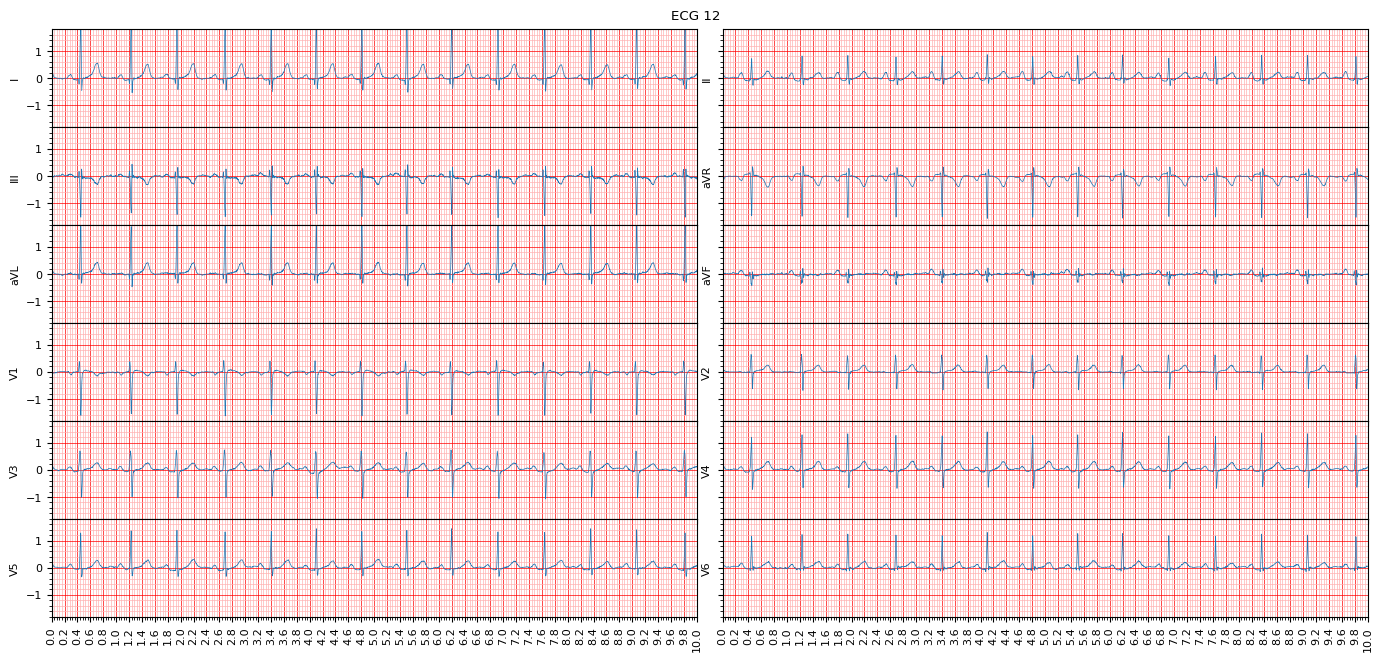

In [68]:
ecg_plot.plot_12(X[0]/500, sample_rate=500)